In [10]:
from experiments import experiments
from agents import DQNAgent
from environments import DelaySampleToMatchEnv
from eval_scripts import prepare_data
import numpy as np
import matplotlib.pyplot as plt

experiment = experiments[('short-seq', 'cifar10-seq', 'MSELoss', 'RNN')]
env = DelaySampleToMatchEnv(n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 100
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden().to(agent.device)
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        hids.append(hidden.detach().cpu().numpy())


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)


RNNQNetwork(
  (rnn): RNN(10, 64)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
(1200, 64)
[[ 0.9421792  -0.9368436  -1.         ... -1.         -0.98607945
   0.99998444]
 [-0.9989197  -1.         -0.99160165 ...  0.03977118 -0.99999565
   1.        ]
 [-1.         -0.9999868   0.99999624 ...  0.99999845  0.9996685
   0.99999934]
 ...
 [ 0.99886113 -0.9999985   1.         ...  0.9999896   1.
   0.9999997 ]
 [-0.9998376  -0.9998466   1.         ... -0.94806147 -0.99997354
   0.99998736]
 [-0.74281716 -1.          1.         ...  0.6913849   1.
   0.9999964 ]]


(64, 1200)
2024-07-19 09:33:45,488 [INFO] normalizing data across axis=1
2024-07-19 09:33:45,490 [INFO] projecting out mean along axis=0
2024-07-19 09:33:45,494 [INFO] data normalized, 0.01sec
2024-07-19 09:33:45,495 [INFO] sorting activity: 64 valid samples by 100 timepoints
2024-07-19 09:33:45,519 [INFO] n_PCs = 10 computed, 0.03sec
2024-07-19 09:33:45,536 [INFO] 5 clusters computed, time 0.05sec
2024-07-19 09:33:45,555 [INFO] clusters sorted, time 0.07sec
2024-07-19 09:33:45,597 [INFO] clusters upsampled, time 0.11sec
2024-07-19 09:33:45,600 [INFO] rastermap complete, time 0.11sec


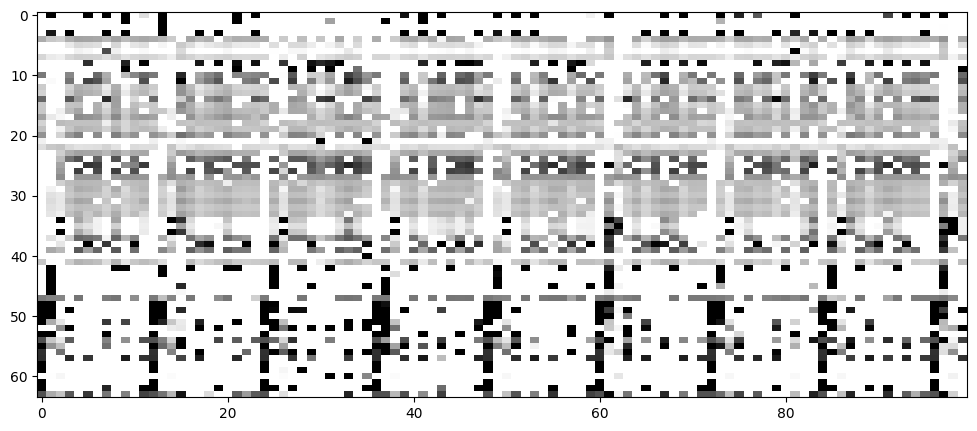

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

spks=hids.T
print(spks.shape)
spks = zscore(spks, axis=1)
spks=spks[:,:100]
# fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5, 
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
#n_samples, n_features
print(hids.shape)
pcs=pca.fit_transform(hids)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
%matplotlib

# Create a repeating pattern of indices for colors
num_points = len(pcs)
cycle_length = 12
indices = np.arange(num_points) % cycle_length

# Normalize the indices to fit within the range of the colormap
norm = Normalize(vmin=0, vmax=cycle_length-1)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2], c=indices, cmap='bwr', norm=norm)
plt.colorbar(scatter, ticks=range(cycle_length))
plt.show()

(1200, 64)


<IPython.core.display.Javascript object>